### Import

In [56]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import metrics
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.feature_selection import SelectKBest, f_classif


### Load data

In [57]:
def load_data():
    # this_directory = os.path.dirname(os.path.abspath(__file__))
    data = pd.read_csv(os.path.join('hn', 'HN_radiomicFeatures.csv'), index_col=0)

    return data

data = load_data()
label = data["label"]
data = data.drop(["label"], axis=1)
feature_names = data.columns.values
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 113
The number of columns: 159


### Check for missing data

In [58]:
# Detect missing values in dataframe
data.isnull().values.any()

False

### Exclude features with zero variance

In [59]:
# exclude features with zero variances
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
selector.fit_transform(data)
selector.fit_transform(data).shape

(113, 157)

### Data split

In [67]:
def split_data(data, label):
    train_data, test_data, train_label, test_label = train_test_split(data, label, train_size=0.8)
    return train_data, test_data, train_label, test_label
# train_data, val_data, train_label, val_label = train_test_split(train_val_data, train_val_label, train_size=0.85)

train_data, test_data, train_label, test_label = split_data(data, label)
print(f'The number of train samples: {train_data.shape[0]}')
# print(f'The number of validation samples: {val_data.shape[0]}')
print(f'The number of test samples: {test_data.shape[0]}')

The number of train samples: 90
The number of test samples: 23


### Scaling train data

In [68]:
def scale_data(train_data, test_data, feature_names):
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    test_data = pd.DataFrame(test_data, columns=feature_names)
    return train_data, test_data

train_data, test_data = scale_data(train_data, test_data, feature_names)

### Linear Classifier

In [69]:
clf = SGDClassifier()
clf.fit(train_data, train_label)
print(np.shape(clf.coef_))
print(clf.intercept_)

label_train_pred = clf.predict(train_data)
print(metrics.accuracy_score(train_label, label_train_pred))

y_pred = clf.predict(test_data)
print(metrics.accuracy_score(test_label, y_pred))

(1, 159)
[-88.35968607]
1.0
0.6086956521739131


### kNN classifier

In [74]:
# Perform a PCA
def perform_pca(train_data, test_data, n_components):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(train_data)
    train_pca = pca.transform(train_data)
    test_pca = pca.transform(test_data)
    return pca, train_pca, test_pca

pca, train_pca, test_pca = perform_pca(train_data, test_data, 10)
print(sum(pca.explained_variance_ratio_))

# Fit kNN
def knn_classifier(train_pca, test_pca, train_label, test_label):
    knn = neighbors.KNeighborsClassifier(n_neighbors=10)
    knn.fit(train_pca, train_label)
    score_train = knn.score(train_pca, train_label)
    score_test = knn.score(test_pca, test_label)
    return score_train, score_test

score_train, score_test = knn_classifier(train_pca, test_pca, train_label, test_label)

# Print result
print(f"Training result: {score_train}")
print(f"Test result: {score_test}")

0.7171368742620623
Training result: 0.7888888888888889
Test result: 0.43478260869565216


C:\Users\velde\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [145 146] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\velde\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


                 score  rank
sf_volume_2D  16.14097    27


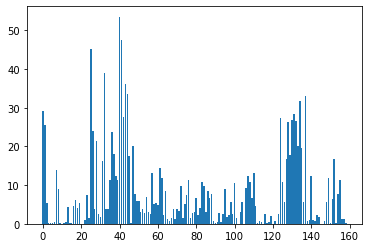

In [75]:
# You can understand the F-Scores as a measure of how informative each feature is for your dataset.
# As it is explained in the method documentation, an F-test is carried out to assess each feature. 
# The F-scores are the test statistic for the F-test, and they basically represent the ratio between the explained and the unexplained variance.

fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(train_data, train_label)
scores = np.zeros(len(fs.scores_))

for i in range(len(fs.scores_)):
	# print('Feature %d: %f' % (i, fs.scores_[i]))
	scores[i] = fs.scores_[i]

rank = range(len(scores))

scores = pd.DataFrame(scores, columns=["score"], index=feature_names)
scores = scores.sort_values(by=["score"], ascending=False)
scores["rank"] = rank

volume = scores.loc[["sf_volume_2D"]]
print(volume)

pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

### Find average accuracy over multiple classifications

In [76]:
# Find mean accuracy for 10 kNN classifications
loops = 100
score_train_array = np.zeros(loops)
score_test_array = np.zeros(loops)
pca_components = 10

for i in range(loops):
    train_data, test_data, train_label, test_label = split_data(data, label)
    train_data, test_data = scale_data(train_data, test_data, feature_names)

    # Perform a PCA
    pca, train_pca, test_pca = perform_pca(train_data, test_data, pca_components)

    # Fit kNN
    score_train, score_test = knn_classifier(train_pca, test_pca, train_label, test_label)
	score_train_array[i] = score_train
	score_test_array[i] = score_test


mean_score_train = np.mean(score_train_array)
mean_score_test = np.mean(score_test_array)
print(f"Mean training score: {mean_score_train}")
print(f"Mean test score: {mean_score_test}")

0.7444444444444445
0.6956521739130435
Mean training score: 0.7444444444444445
Mean test score: 0.6956521739130435
